## Video Generator

I will try to generate new Siraj Raval's video by using convolutional variational autoencoder (CVAE) and rnn.

Steps:
* Train CVAE on frames of [this](https://www.youtube.com/watch?v=3-UDwk1U77s) video (video is resized to 64x64, it will be cool if someone tries higher resolutions).
* Use learned hidden representations of CVAE to train rnn (use them as inputs and labels, this way we are going to learn temporal patterns of frames).
* Generate new video frames by using trained CVAE and use hidden representations of those frames as inputs to rnn.
* Use rnn outputs (same dim. as hidden representations) as inputs of CVAE's decoder to map them into data set distribution.
* And that's it!

In [1]:
#import dependencies

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from conv_vae import ConvVAE
from data_utils import read_dataset
import time
from scipy.stats import norm

In [2]:
# read data set
train_ds, valid_ds = read_dataset('data/frames', test_size = 0.097)
print train_ds.images().shape
print (train_ds.images().nbytes + valid_ds.images().nbytes) / (1024.0 * 1024.0), 'MB'

(10003, 64, 64, 3)
519.28125 MB


In [3]:
latent_dim = 10
batch_size = 50

# let's create ConvVAE
cvae = ConvVAE(latent_dim, batch_size)

This is what ConvVAE outputs before training:

![figure_1](images/figure1.png "figure1")
![figure_2](images/figure2.png "figure2")

In [4]:
# let's train ConvVAE
num_epochs = 15
interval = 200

saver = tf.train.Saver(max_to_keep = 2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    t = time.time()
    # for num of epochs    
    while(train_ds.epochs_completed() < num_epochs):
        
        current_epoch = train_ds.epochs_completed()
        step = 0
        print '[----Epoch {} is started ----]'.format(current_epoch)
        
        # take next batch until epoch is completed        
        while(train_ds.epochs_completed() < current_epoch + 1):
            input_images = train_ds.next_batch(batch_size)
            # do training step
            cvae.training_step(sess, input_images)
            step += 1
            
            if step % interval == 0:
                print 'loss: {} validation loss: {}'.format(cvae.loss_step(sess, input_images),\
                                                            cvae.loss_step(sess, valid_ds.next_batch(batch_size)))
                
        print '[----Epoch {} is finished----]'.format(current_epoch)
        saver.save(sess, 'checkpoints/', global_step=current_epoch)
        print '[----Checkpoint is saved----]'
     
    print 'Training time: {}s'.format(time.time() - t)
    
    # let's see how well our model reconstructs input images       
    input_images = train_ds.next_batch(batch_size)

    output_images = cvae.recognition_step(sess, input_images)
    output_images = output_images * 255
    output_images = output_images.astype(np.uint8)
    print 'Shape= ', output_images.shape

[----Epoch 0 is started ----]
loss: 6185.39794922 validation loss: 5644.12890625
[----Epoch 0 is finished----]
[----Checkpoint is saved----]
[----Epoch 1 is started ----]
loss: 4702.40771484 validation loss: 4614.16699219
[----Epoch 1 is finished----]
[----Checkpoint is saved----]
[----Epoch 2 is started ----]
loss: 4575.64892578 validation loss: 4430.48388672
[----Epoch 2 is finished----]
[----Checkpoint is saved----]
[----Epoch 3 is started ----]
loss: 4642.93652344 validation loss: 4595.05224609
[----Epoch 3 is finished----]
[----Checkpoint is saved----]
[----Epoch 4 is started ----]
loss: 4416.30957031 validation loss: 4626.60498047
[----Epoch 4 is finished----]
[----Checkpoint is saved----]
[----Epoch 5 is started ----]
loss: 4151.33447266 validation loss: 3910.6394043
[----Epoch 5 is finished----]
[----Checkpoint is saved----]
[----Epoch 6 is started ----]
loss: 3844.89379883 validation loss: 4318.27539062
[----Epoch 6 is finished----]
[----Checkpoint is saved----]
[----Epoch 7 i

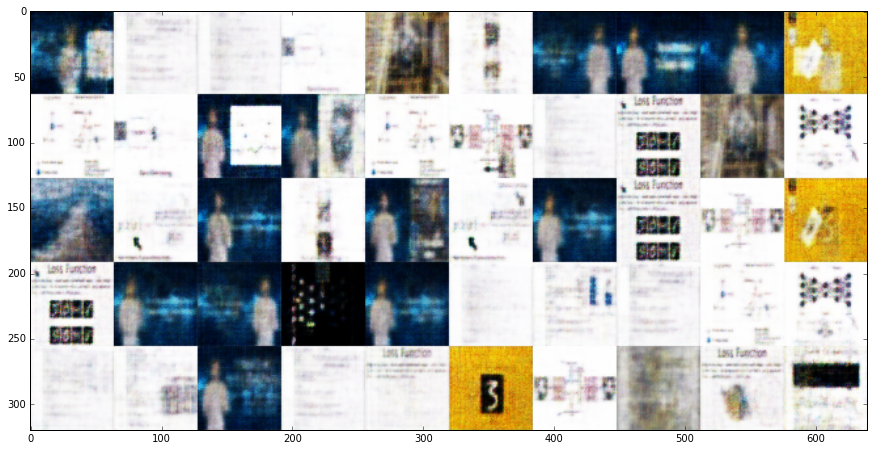

In [10]:
# Let's plot them!!!

w = 10
h = 5
figure = np.zeros([64 * h, 64 * w, 3], dtype = np.uint8)
k = 0
for i in range(h):
    for j in range(w):
        image = np.reshape(output_images[k], [64, 64, 3])
        figure[i * 64: (i + 1) * 64,
               j * 64: (j + 1) * 64,
               :] = image
        k += 1
    
plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()

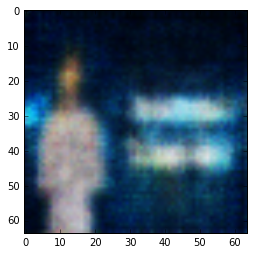

In [13]:
# Let's take a look at some of them separately
plt.imshow(np.reshape(output_images[7], [64, 64, 3]))
plt.show()

## Well that's definitely Siraj on that image

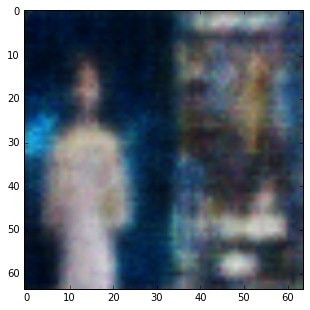

In [14]:
# Let's see another one
plt.figure(figsize = (5, 5))
plt.imshow(np.reshape(output_images[24], [64, 64, 3]))
plt.show()

That's it for now, stay tuned because more exciting things are comming (just don't have time to finish it now because I will miss the deadline for the coding challenge). For now these are just reconstructed video frames, but also you can generate new ones easily by using this cvae (will upload saved model). Next thing to do is to train rnn with hidden representations (latent vectors) of video frames as inputs and also labels. This way rnn will learn temporal patterns of frames and after that we can use new video frames generated by cvae to make a whole new Siraj Raval's video. Who knows maybe one day Siraj will lose his job as Youtuber because of AI :-) .

## The project will be finished until the end of this week.

## Generate a new video frame

z= [-1.03643334 -1.64485359  0.3853204   1.03643346  0.3853204   1.03643346
 -0.38532048  0.67448974  1.64485347 -1.03643334]
Shape= (1, 64, 64, 3)


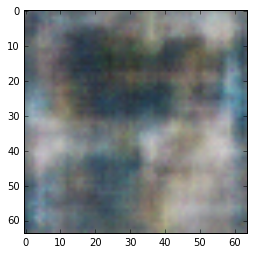

In [54]:
# reset computational graph
tf.reset_default_graph()

# create model
cvae = ConvVAE(latent_dim, batch_size = 1)

# restoration
saver = tf.train.Saver()
path = tf.train.latest_checkpoint('checkpoints')

with tf.Session() as sess:
    # restore session    
    saver.restore(sess, path)
    
    # let's create random latent vector from normal distribution     
    # z = np.random.normal(size = latent_dim)
    
    vals = np.array([np.linspace(0.05, 0.95, latent_dim, dtype = np.float32) for i in range(latent_dim)])
    vals = np.reshape(vals, [latent_dim * latent_dim])
    z_samples = norm.ppf(vals)
    z_samples = np.random.permutation(z_samples)
            
    print 'z=',z_samples[:latent_dim]
    
    # Generate a new video frame
    output_image = cvae.generation_step(sess, np.reshape(z_samples[:latent_dim], [1, latent_dim]))
    output_image = output_image * 255
    output_image = output_image.astype(np.uint8)
    
    print 'Shape=',output_image.shape
    
    # plot it
    plt.imshow(np.reshape(output_image, [64, 64, 3]))
    plt.show()

## It looks like there are two Sirajs on that video frame

Little bit enhanced:
![frame](images/frame.png "frame")